In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from resnet import resnet152
from tqdm import tqdm
from apex import amp
from torch_lr_finder import LRFinder



plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
print(data_transforms)

{'train': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'val': Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [4]:
data_dir = './dataset-split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=28,
                                             shuffle=True, num_workers=26)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


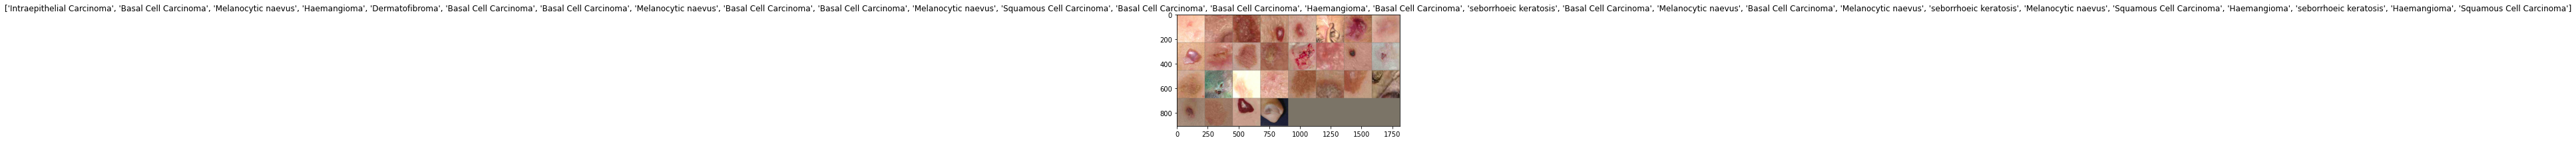

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # print(torch.cuda.memory_stats(device)['active.all.allocated'])

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        with amp.scale_loss(loss, optimizer) as scaled_loss:
                            scaled_loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch_loss, epoch_acc, len(dataloaders[str(phase)]),
                100. * epoch_acc / len(dataloaders[str(phase)])))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = resnet152(progress=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# "cuda:0" if torch.cuda.is_available() else
# model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(512, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.000209, betas=(0.9, 0.999), eps=1e-8)

model_ft, optimizer_ft = amp.initialize(model_ft, optimizer_ft, opt_level="O1")

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler.reset()
exp_lr_scheduler = LRFinder(model_ft, optimizer_ft, criterion, device=device)
exp_lr_scheduler.range_test(dataloaders['train'], val_loader=dataloaders['val'], start_lr=0.001, end_lr=1.5, num_iter=100, step_mode="exp")
# exp_lr_scheduler.range_test(dataloaders['train'], end_lr=10, num_iter=100, step_mode="exp")
exp_lr_scheduler.plot()


In [13]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]Epoch 1/50
----------
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
  0%|          | 0/50 [22:37<?, ?it/s]


AttributeError: 'LRFinder' object has no attribute 'step'

In [14]:
torch.save(model_ft.state_dict(), 'model/resnet_lesions_v3.pt')

In [2]:
!pip install shap
import shap

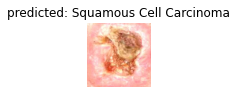

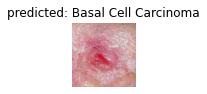

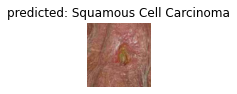

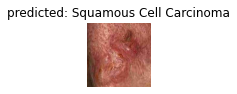

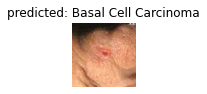

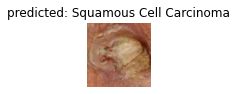

In [13]:
visualize_model(model_ft)

In [4]:
from PIL import Image


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from torchvision import transforms

import torch.nn.functional as F

idx_to_labels = class_names

model = models.resnet152()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('model/resnet_lesions.pt'))
model.eval().to(device)
# visualize_model(model)

batch = next(iter(dataloaders['test']))
images, _ = batch


output = model(images[0].unsqueeze(0).to(device))

output = F.softmax(output, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[pred_label_idx.item()]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = DeepLift(model)
attributions_ig = integrated_gradients.attribute(images.to(device), target=pred_label_idx)

# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)


Predicted: Squamous Cell Carcinoma ( 0.6883917450904846 )
/home/matheuscosta/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/matheuscosta/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 7.93 GiB total capacity; 6.33 GiB already allocated; 97.31 MiB free; 6.45 GiB reserved in total by PyTorch)

In [31]:
model = resnet152(pretrained=False, progress=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(512, len(class_names))
model.load_state_dict(torch.load('model/resnet_lesions_v2.pt'))
model.eval().to(device)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 6.22 GiB already allocated; 55.19 MiB free; 6.24 GiB reserved in total by PyTorch)

In [40]:
# !pip install tensorflow
batch = next(iter(dataloaders['test']))
images, _ = batch
background = images[:100].to("cpu")
print(background)
test_images = images[0:3]
print(test_images)
e = shap.DeepExplainer(model_ft.to("cpu"), background)
test_images.shape, background.shape

tensor([[[[ 1.2899,  1.2899,  1.2899,  ...,  1.5297,  1.5639,  1.5810],
          [ 1.3413,  1.3413,  1.3413,  ...,  1.5639,  1.5810,  1.5810],
          [ 1.4269,  1.4269,  1.4440,  ...,  1.6324,  1.5982,  1.5982],
          ...,
          [ 1.6495,  1.6495,  1.7009,  ...,  1.9920,  1.9920,  1.9920],
          [ 1.7523,  1.7694,  1.7694,  ...,  2.0263,  2.0092,  1.9920],
          [ 1.8208,  1.8208,  1.8037,  ...,  2.0434,  2.0092,  1.9920]],

         [[ 0.6254,  0.6254,  0.6254,  ...,  0.6954,  0.7304,  0.7479],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.7304,  0.7479,  0.7479],
          [ 0.7654,  0.7654,  0.7829,  ...,  0.8004,  0.7654,  0.7654],
          ...,
          [ 0.5903,  0.6078,  0.6604,  ...,  1.1681,  1.1681,  1.1681],
          [ 0.6954,  0.7129,  0.7304,  ...,  1.2031,  1.1856,  1.1681],
          [ 0.7654,  0.7654,  0.7654,  ...,  1.2206,  1.1856,  1.1681]],

         [[ 0.4962,  0.4962,  0.4962,  ...,  0.6182,  0.6531,  0.6705],
          [ 0.5485,  0.5485,  

(torch.Size([3, 3, 224, 224]), torch.Size([28, 3, 224, 224]))

In [41]:
shap_values = e.shap_values(test_images)
print(shap_values)

RuntimeError: The size of tensor a (512) must match the size of tensor b (2048) at non-singleton dimension 1

In [32]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
print(shap_numpy)
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

[array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64), array([], shape=(0, 224, 224, 3), dtype=float64)]


ValueError: Number of rows must be a positive integer, not 0